# Workspace preparation

In [1]:
# Importing packages
import numpy as np  # for matrix and data manipulation
import pandas as pd  # for DataFrames
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for more plotitng
import statsmodels.api as sm  # for statistical modelling
import scikitplot as skplt  # for scikit-learn plotting

from sklearn.preprocessing import StandardScaler  # for preprocessing & scaling
from sklearn.preprocessing import PolynomialFeatures  # for polynomial features preprocessing
from sklearn.impute import SimpleImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.model_selection import StratifiedKFold  # K-fold resampling, stratified
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning
from sklearn.calibration import CalibratedClassifierCV  # Hyperparameter tuning with calibration
from sklearn.calibration import calibration_curve  # calibration curve plotting
from sklearn.calibration import CalibrationDisplay  # calibration curve plotting
from sklearn.metrics import confusion_matrix  # performance metrics, confusion matrix
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.metrics import roc_auc_score  # Area Under Receiver Operating Characteristics
from sklearn.metrics import roc_curve  # ROC
from sklearn.metrics import RocCurveDisplay  # ROC plotting
from sklearn.metrics import accuracy_score  # performance metric accuracy (0/1) score
from sklearn.metrics import precision_score  # performance metric
from sklearn.linear_model import LogisticRegression  # Logistic regression modelling
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn.svm import SVC  # SVM for classification
from sklearn.utils import resample  # Resampling
from imblearn.over_sampling import SMOTE  # Synthetic upsampling

In [2]:
# Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Jupyter magic command to show plots inline immediately
%matplotlib inline

In [4]:
# Setting seed
seed = 43
np.random.seed(seed)

# Loading the data

In [5]:
# Loading the house price dataset
data_file_path = './'  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

# Training data
train_V2 = pd.read_csv(data_file_path + 'train_V2.csv')
score = pd.read_csv(data_file_path + 'score.csv')
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))

#dictionary = pd.read_csv(data_file_path + 'dictionary.csv')
#print('Dictionary set shape: {}' .format(score.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#print(train_V2.columns.tolist())
for col in score.columns.tolist():
    print(col)

income_am
profit_last_am
profit_am
damage_am
damage_inc
crd_lim_rec
credit_use_ic
gluten_ic
lactose_ic
insurance_ic
spa_ic
empl_ic
cab_requests
married_cd
bar_no
sport_ic
neighbor_income
age
marketing_permit
urban_ic
dining_ic
presidential
client_segment
sect_empl
prev_stay
prev_all_in_stay
divorce
fam_adult_size
children_no
tenure_mts
tenure_yrs
company_ic
claims_no
claims_am
nights_booked
gender
shop_am
shop_use
retired
gold_status
score1_pos
score1_neg
score2_pos
score2_neg
score3_pos
score3_neg
score4_pos
score4_neg
score5_pos
score5_neg


In [7]:
# Setting 'Id' columns as index
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

# Data preparation
## What do we need to predict? Is it available as outcome in our data
1. the revenue per client (= profit - damage)
    - needs to be calculated
2. predict which clients will cause damage
    - outcome_damage_inc
3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

Calculate revenue

In [8]:
# The outcome to maximize is profit - damage
train_V2['revenue'] = train_V2['outcome_profit'] - train_V2['outcome_damage_amount']

All the variables seem to be numeric, except for the  `gender` : contains 'M' or 'V', replace by numeric value

In [9]:
#
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

# Initial exploration of data

In [10]:
train_V2[train_V2['outcome_damage_inc']==1].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount,revenue
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66,843.12
6,13293.0,28.0,14704.0,0.0,0.0,15000.0,0.0,1.0,1.0,1.0,1.0,0.0,8.0,True,18.0,0.0,33459.0,46.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,2.0,324.0,27.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,1.0,0.566906,0.846320,0.595743,0.901703,NaN,NaN,NaN,NaN,NaN,NaN,1676.75,1,888.09,788.66
9,229.0,810.0,1620.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,True,6.0,0.0,31718.0,29.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,145.0,12.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.196373,0.318601,NaN,NaN,NaN,NaN,1861.78,1,981.64,880.14
10,7177.0,2887.0,3770.0,0.0,0.0,15000.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,True,11.0,0.0,34575.0,53.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,167.0,14.0,0.0,0.0,0.0,19.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.222590,0.130548,NaN,NaN,0.276508,0.882461,NaN,NaN,1761.14,1,483.05,1278.09
11,3240.0,1212.0,2750.0,2762.0,6.0,12000.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,True,9.0,1.0,31135.0,53.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,477.0,40.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.390233,0.526528,NaN,NaN,NaN,NaN,0.044849,0.649934,NaN,NaN,2109.04,1,1046.70,1062.34


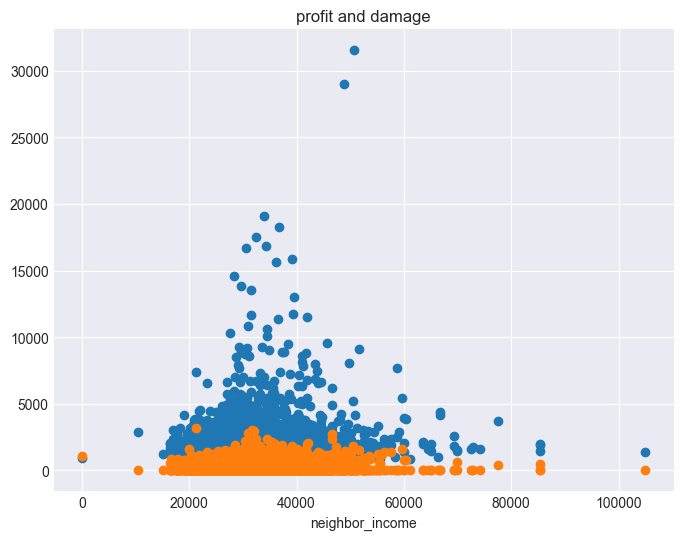

In [12]:
# Plotting
x = 'neighbor_income'
plt.figure(figsize=(8, 6))
plt.scatter(x=train_V2[x], y=train_V2['outcome_profit']);
plt.scatter(x=train_V2[x], y=train_V2['outcome_damage_amount']);
plt.title('profit and damage');
plt.xlabel(x);

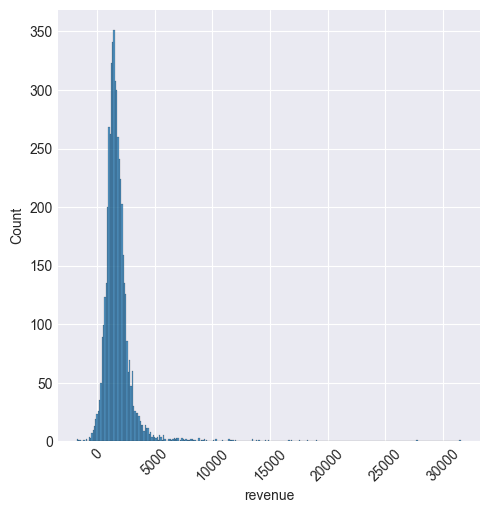

In [14]:
# Checking univariate distribution of the revenue
sns.displot(train_V2['revenue']);  # With seaborn for a change
plt.xticks(rotation=45); # Rotating x labels

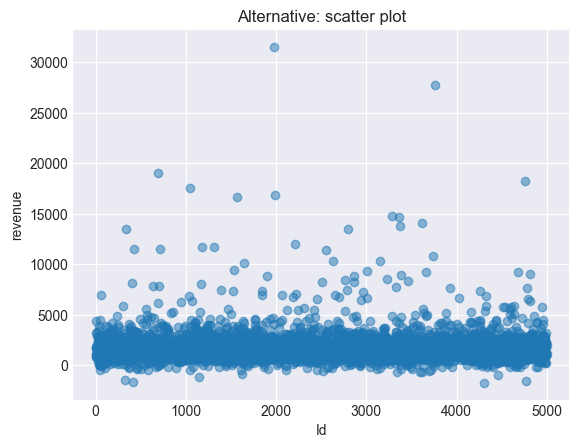

In [19]:
# But I guess a scatter plot would've done well also

plt.scatter(x = range(0, 0 + len(train_V2)),y=train_V2['revenue'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('Id');
plt.ylabel('revenue');
plt.title('Alternative: scatter plot');
plt.show() 

# The data seems to be evenly distributed, no shuffling is needed


# Handle missing data
1. Getting missing values descending per feature
2. Drop features with more than 15% missing values
3. Find instances with missing observations (% of missing for a lot of features is equal > it appears these values for these featues are missing for the same instances)

In [21]:
import scipy.stats as stats

train_V2["score5_neg_uniform"] = ( train_V2["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
train_V2["score5_neg_uniform"] = stats.norm.cdf(train_V2["score5_neg_uniform"])

In [32]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount,revenue,score5_neg_uniform,score_pos,score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,0.0,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00,1791.66,NaN,0.652958,0.532814
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66,843.12,0.808991,NaN,0.808991
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00,1001.40,0.137461,0.167165,0.118495
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00,1785.59,NaN,NaN,0.889793
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00,3140.74,NaN,0.410495,0.654370


<Axes: >

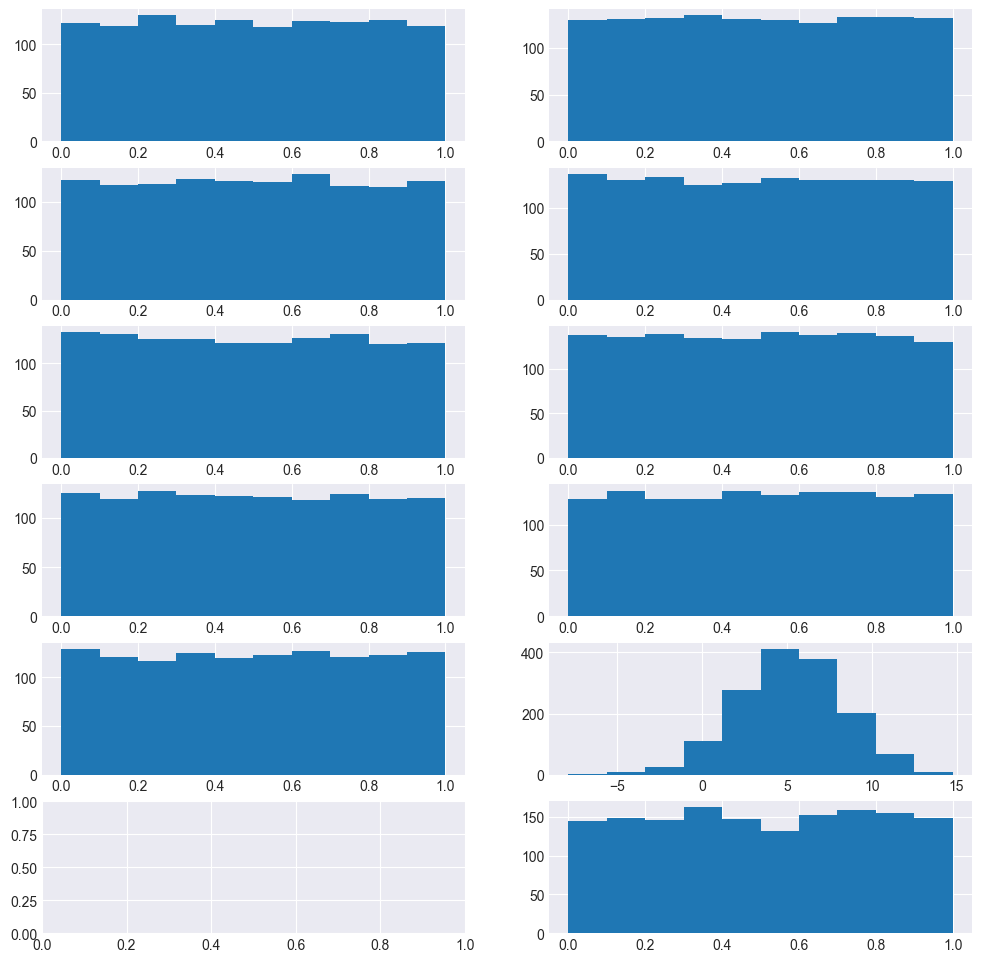

In [34]:
score_pos_features = ['score1_pos','score2_pos','score3_pos','score4_pos','score5_pos']
score_neg_features = ['score1_neg','score2_neg','score3_neg','score4_neg','score5_neg']

fig, axs = plt.subplots(6,2, figsize=(12,12))
i=0
for i in range(1,6):
    train_V2[score_pos_features[i-1]].hist(ax=axs[i-1][0])
    train_V2[score_neg_features[i-1]].hist(ax=axs[i-1][1])

train_V2["score5_neg_uniform"].hist(ax=axs[5][1])


In [29]:
train_V2["score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg_uniform"]].mean(axis=1)

In [15]:
# Calculate mean value for positive or negative score and add to dataframe
data_score_neg = []
data_score_pos = []

for i in range(0, 0 + len(train_V2)):
    score_neg = 0
    score_pos = 0
    nbr_score_neg = 0
    nbr_score_pos = 0
    for score in score_pos_features:
        if not(pd.isnull(train_V2.loc[i,score])):
            score_pos += train_V2.loc[i,score]
            nbr_score_pos += 1
    for score in score_neg_features:
        if not(pd.isnull(train_V2.loc[i,score])):
            score_neg += train_V2.loc[i,score]
            nbr_score_neg += 1
    if nbr_score_neg != 0:
        data_score_neg.append(score_neg / nbr_score_neg)
    else:
        data_score_neg.append(np.nan)
    if nbr_score_pos != 0:
        data_score_pos.append(score_pos / nbr_score_pos)
    else:
        data_score_pos.append(np.nan)
train_V2.insert(train_V2.shape[1], 'mean_score_pos',  data_score_pos)
train_V2.insert(train_V2.shape[1], 'mean_score_neg',  data_score_neg)


In [16]:
# Getting an idea about total missing values
total_missings = train_V2.isnull().sum().sort_values(ascending=False)  # total missng values, sorted
total_missings.head(20)  # Show top 20 most missing features

# Getting an idea about percentage missing values
pct_missings = train_V2.isnull().mean().sort_values(ascending=False)  # average (%) missng values, sorted
pct_missings.head(20)  # Show top 20 most missing features

score2_pos         0.7582
score4_pos         0.7554
score1_pos         0.7550
score5_pos         0.7536
score3_pos         0.7478
score2_neg         0.7392
score1_neg         0.7372
score4_neg         0.7352
score3_neg         0.7266
score5_neg         0.7014
mean_score_pos     0.3194
mean_score_neg     0.2332
tenure_yrs         0.0784
tenure_mts         0.0784
neighbor_income    0.0478
cab_requests       0.0176
shop_use           0.0176
dining_ic          0.0176
presidential       0.0176
profit_last_am     0.0106
dtype: float64

In [17]:
# Remove the features missing mor tha 15% (score*_pos, neg)
print(f"Shape of train_V2 BEFORE dropping missing features: {train_V2.shape}")
missing_a_lot = pct_missings[pct_missings > 0.35].index  # we take from all variables those missing most, and take the row-idx
print(f"Columns missing more than 15% :{missing_a_lot}")
train_V2 = train_V2.drop(missing_a_lot, axis=1)
print(f"Shape of train_V2 AFTER dropping missing features: {train_V2.shape}")

Shape of train_V2 BEFORE dropping missing features: (5000, 56)
Columns missing more than 15% :Index(['score2_pos', 'score4_pos', 'score1_pos', 'score5_pos', 'score3_pos',
       'score2_neg', 'score1_neg', 'score4_neg', 'score3_neg', 'score5_neg'],
      dtype='object')
Shape of train_V2 AFTER dropping missing features: (5000, 46)


In [18]:
#For a number of instances (53) data seems to be missing for a list of features. These will be eliminated from the dataset
missing_data = train_V2[train_V2['prev_stay'].isnull()]
#missing_data.to_csv('missing_data.csv')
print(missing_data.index)
train_V2 = train_V2.drop(missing_data.index)

Index([  90,  306,  474,  517,  670,  790,  996, 1062, 1164, 1261, 1275, 1281,
       1338, 1448, 1696, 1744, 1852, 2058, 2096, 2250, 2348, 2672, 2696, 2734,
       2917, 2956, 3068, 3198, 3213, 3326, 3377, 3494, 3793, 3926, 3952, 3959,
       3990, 4000, 4009, 4138, 4159, 4242, 4392, 4477, 4528, 4545, 4614, 4641,
       4669, 4789, 4851, 4946, 4993],
      dtype='int64', name='Id')


In [19]:
# Total amount of missings
total_total_missings = train_V2.isnull().sum().sum()
print(f'Are there any missings at all anymore, if this is zero, there are none: {total_total_missings}')
# YAY!

Are there any missings at all anymore, if this is zero, there are none: 3661


## Impute missing data
## ***

In [20]:
numeric_cols=[]
non_numeric_cols=[]
for col in train_V2.columns.tolist():
    if col[-2:] == 'am':
        numeric_cols.append(col)
    else:
        non_numeric_cols.append(col)

#non_numeric_cols = train_V2.select_dtypes(exclude='number').columns
print(non_numeric_cols)
train_V2[non_numeric_cols].head()

# Checking frequency table of a feature (xxx)
for col in non_numeric_cols:
    #print(col)
    print(col,f'y_train frequency table:  \n{train_V2[col].value_counts()}')

['damage_inc', 'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic', 'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd', 'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit', 'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl', 'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size', 'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no', 'nights_booked', 'gender', 'shop_use', 'retired', 'gold_status', 'outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount', 'profit-damage', 'mean_score_pos', 'mean_score_neg']
damage_inc y_train frequency table:  
damage_inc
0.0     4010
1.0      482
2.0      243
3.0      124
4.0       61
5.0       14
6.0        8
7.0        2
10.0       1
9.0        1
8.0        1
Name: count, dtype: int64
crd_lim_rec y_train frequency table:  
crd_lim_rec
0.0        2243
15000.0     284
1500.0      232
750.0       225
3000.0      214
4000.0      203
3500.0      202
2500.0      192
4500.0 

# Visualizing / Exploring data

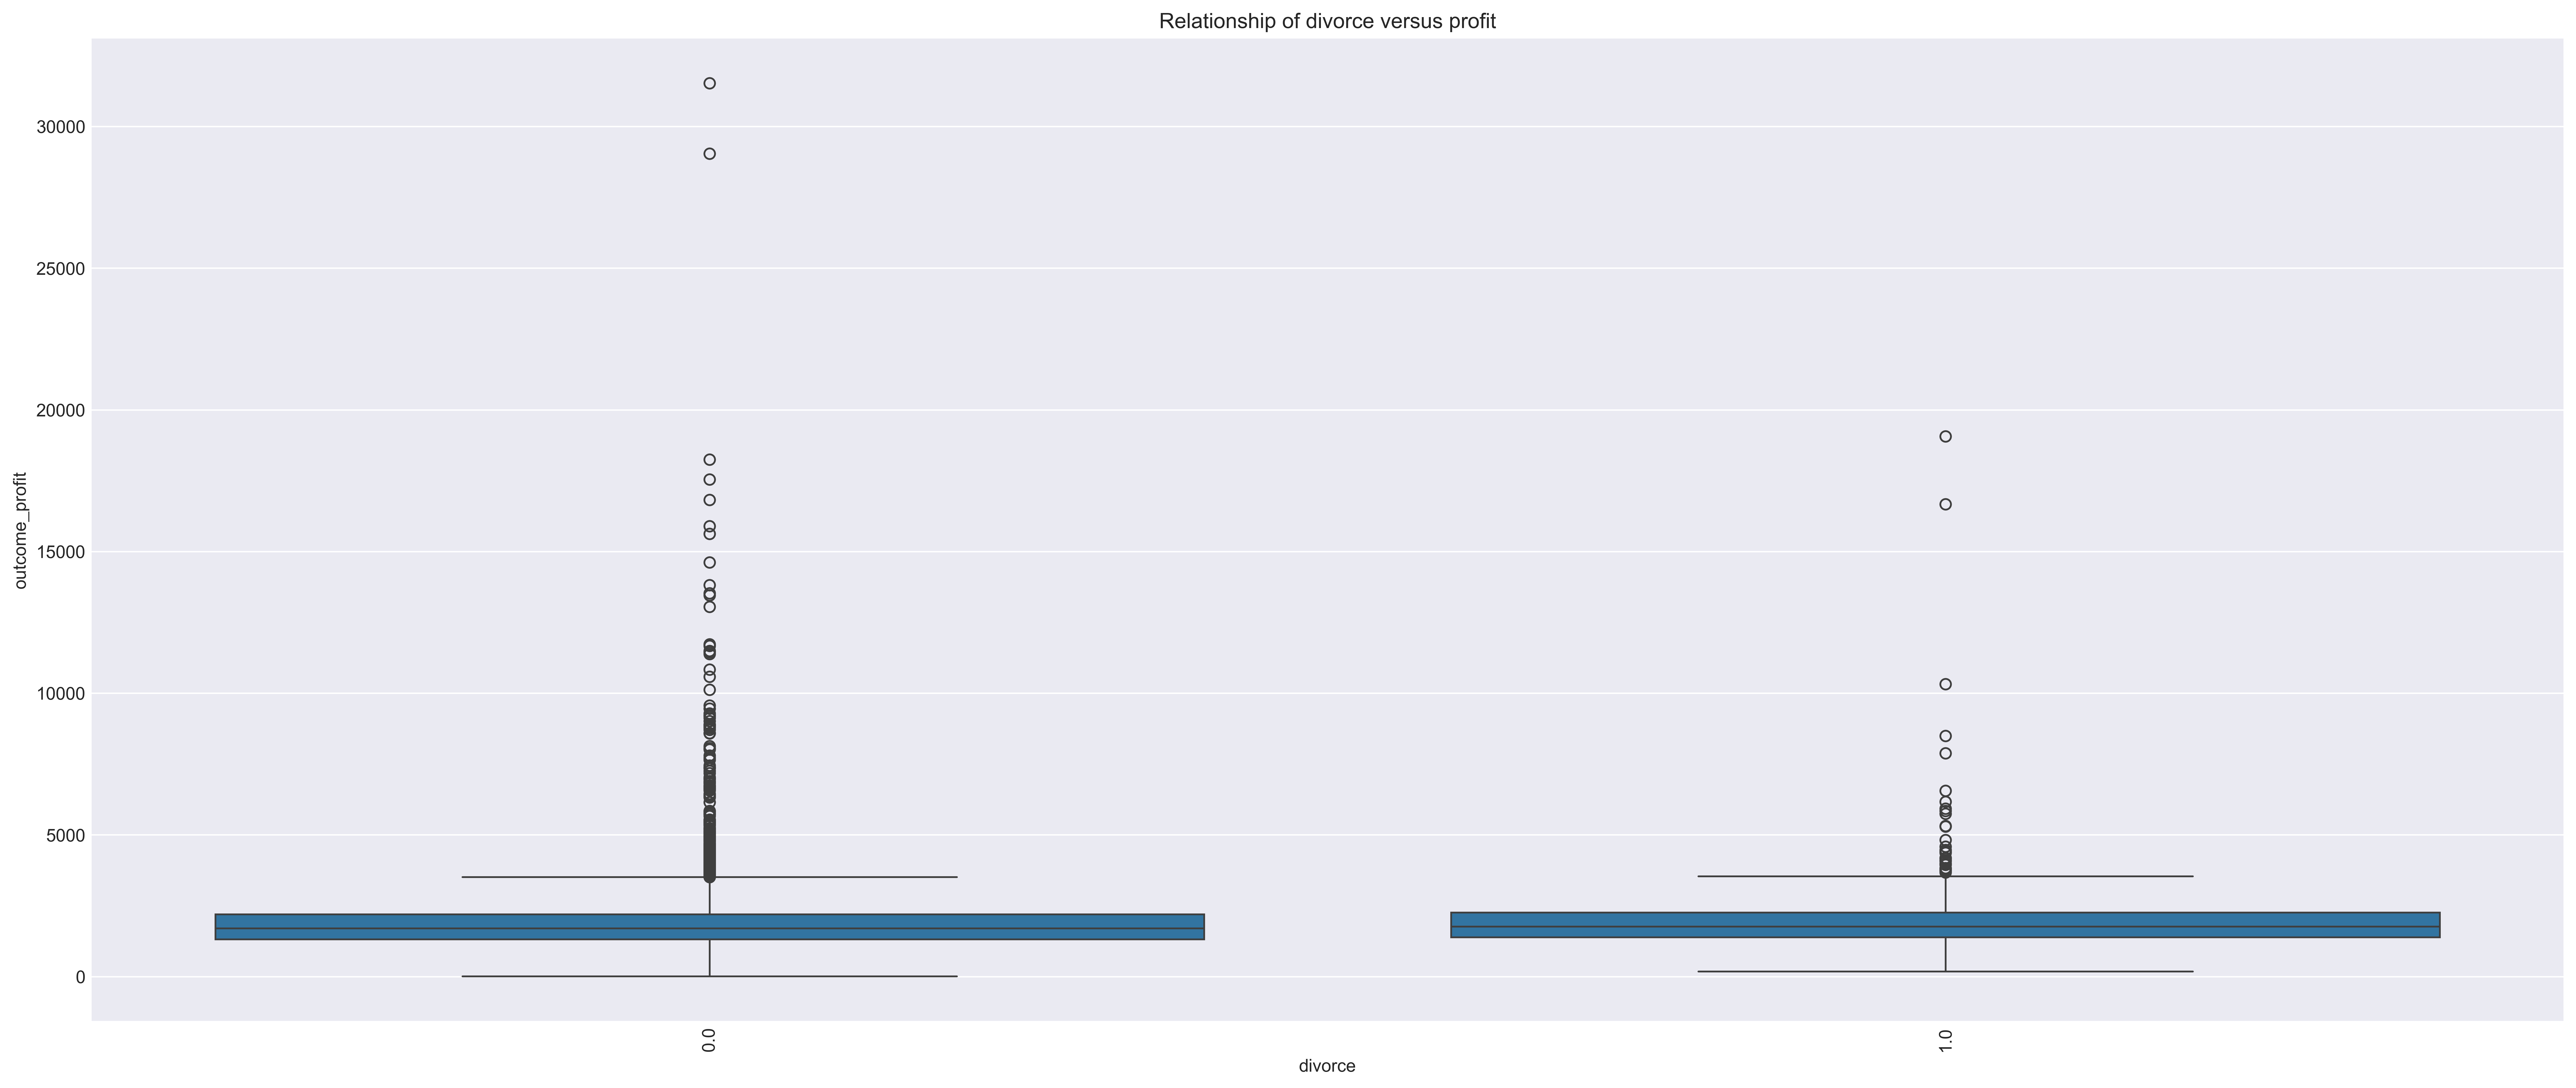

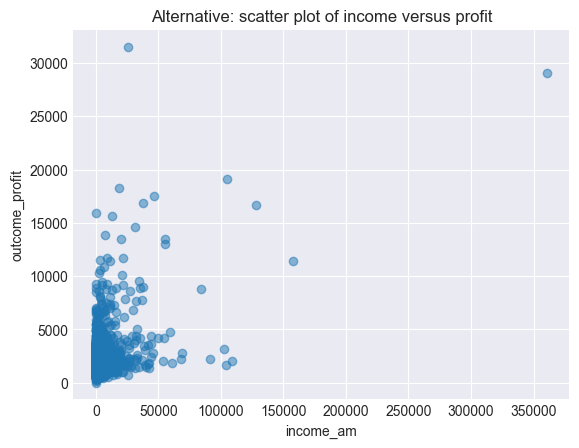

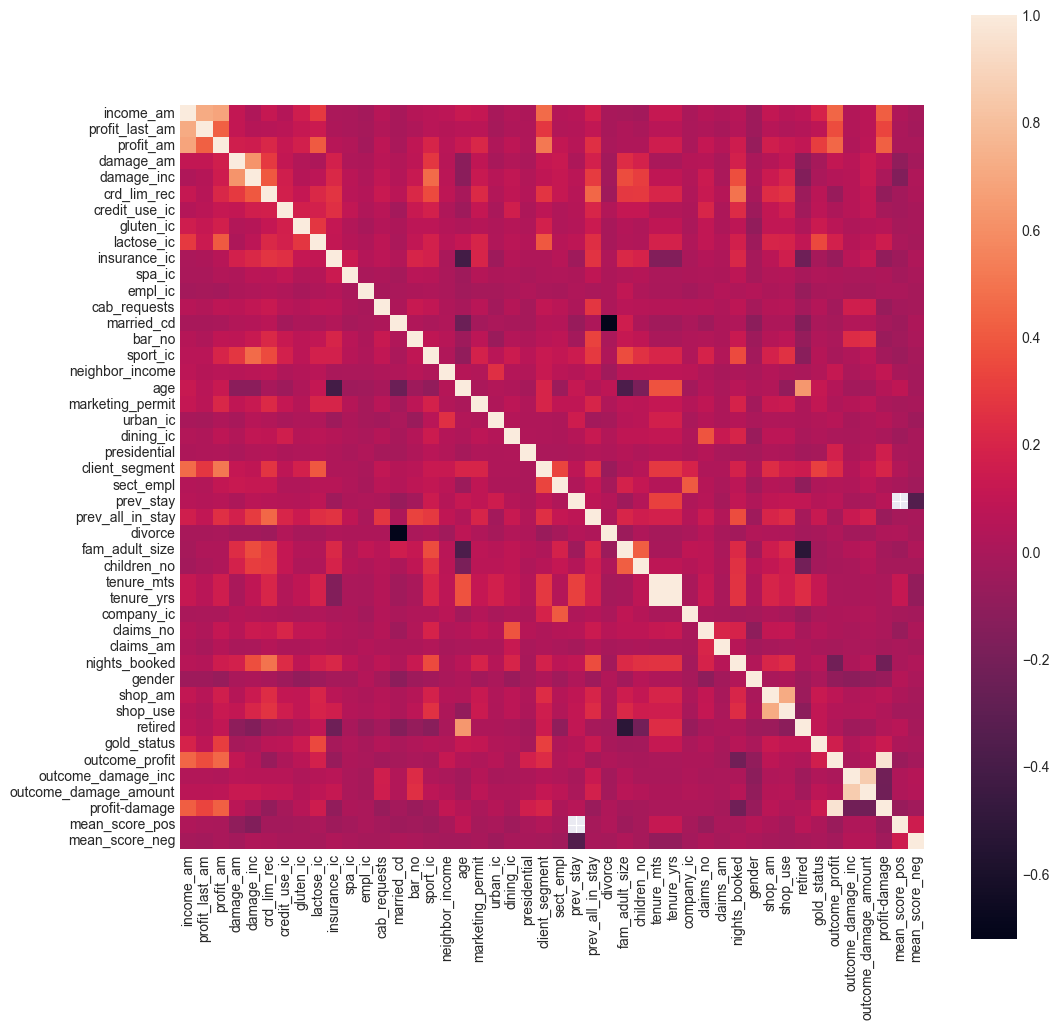

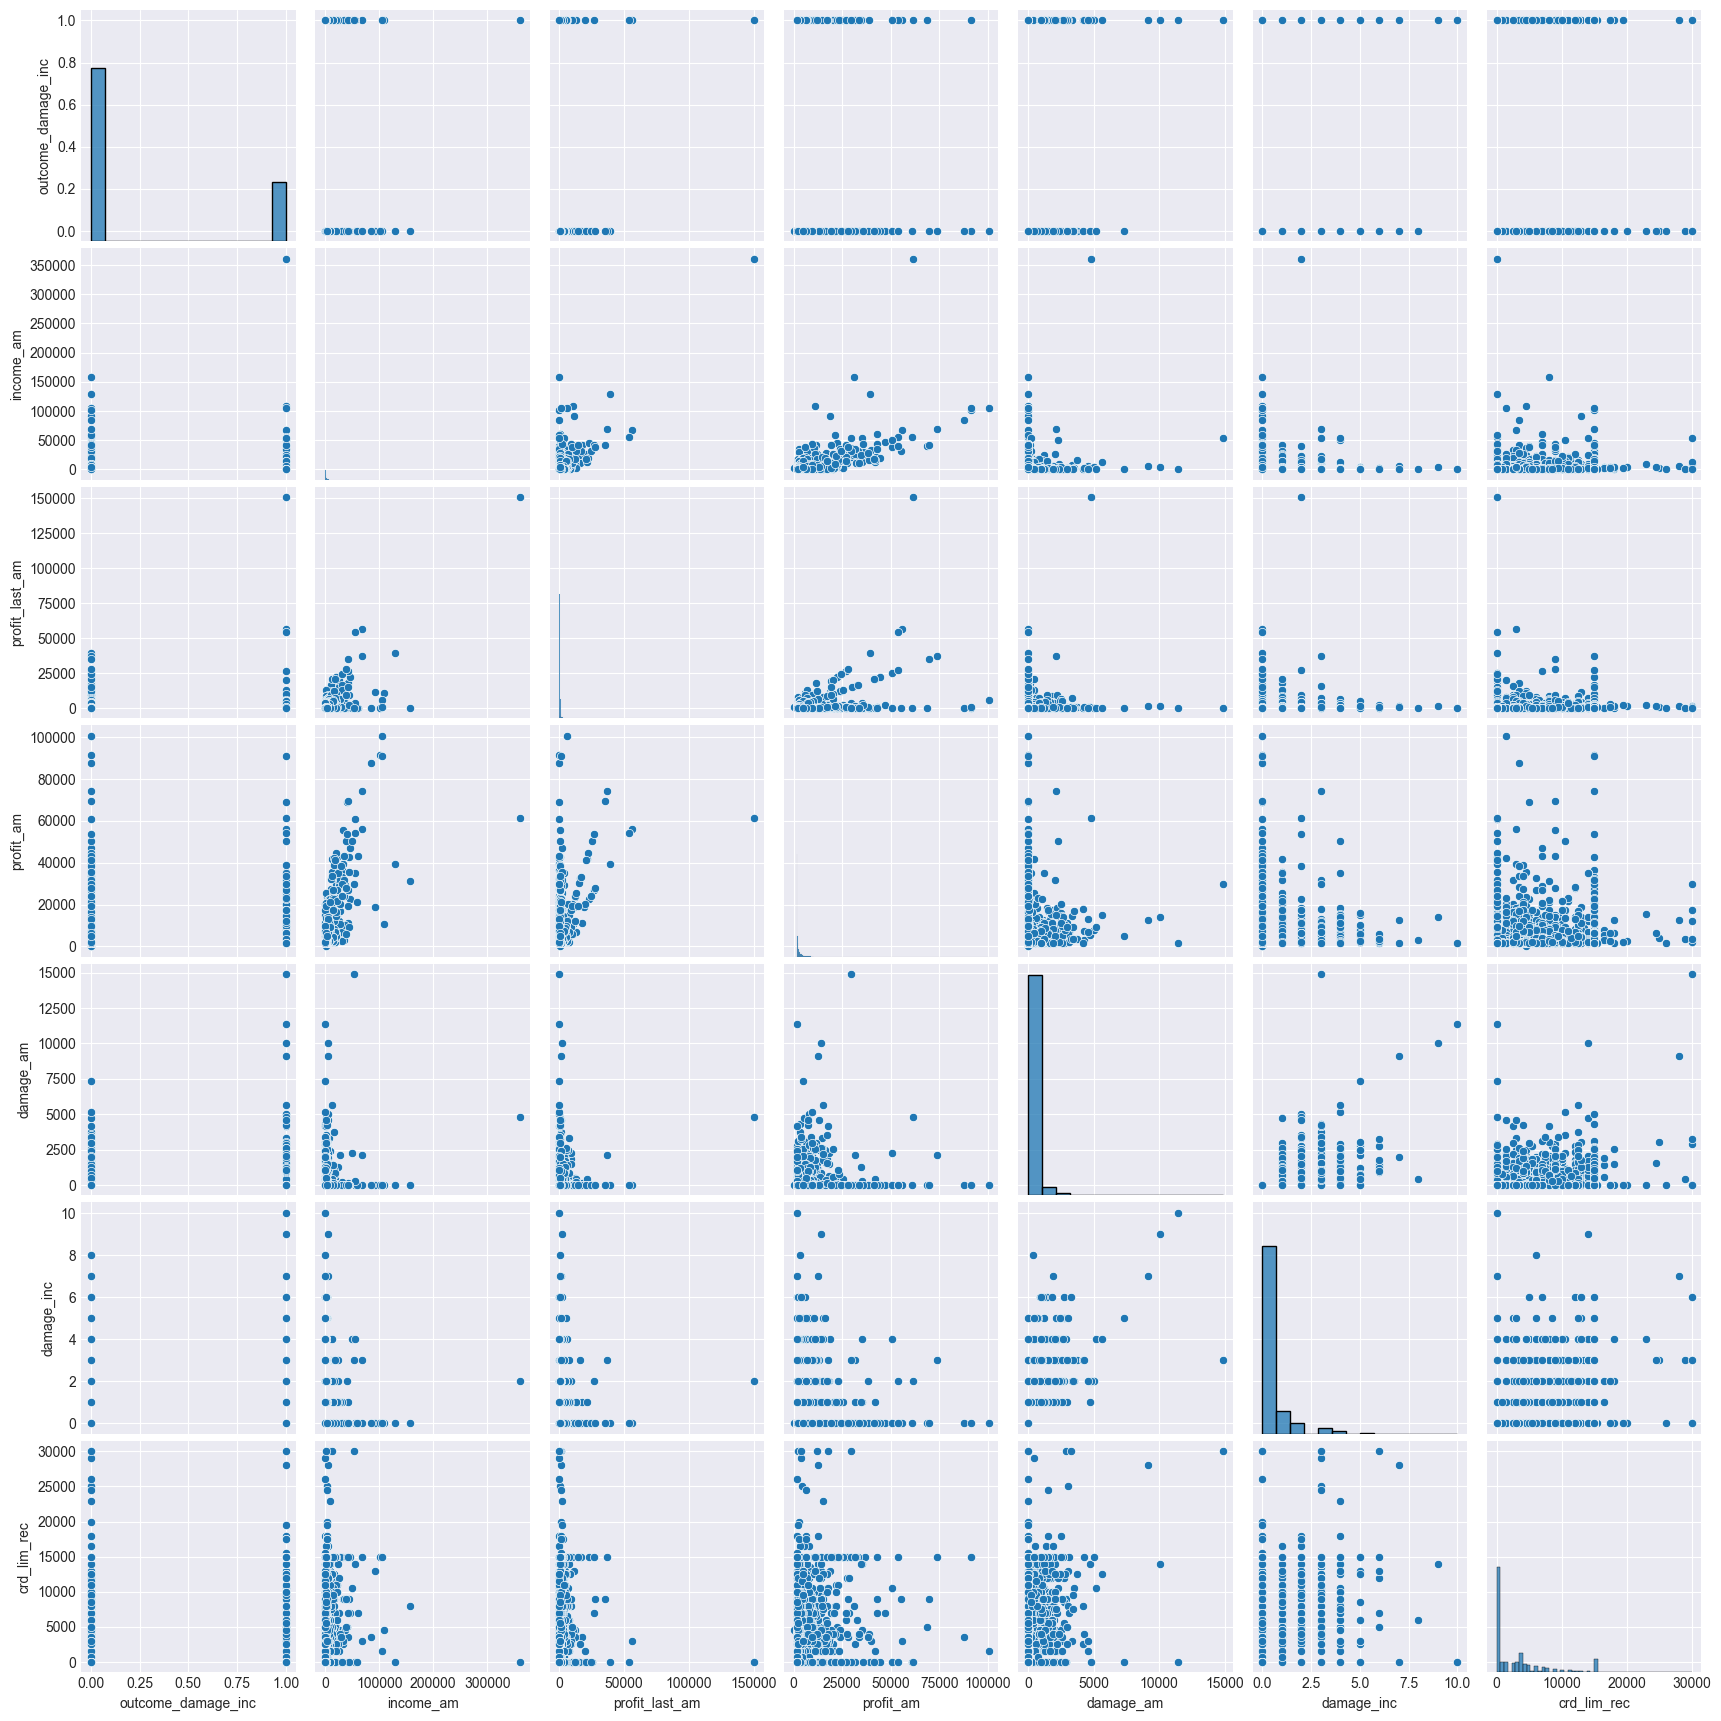

In [21]:
# Boxplot-type for year built vs SalePrice
plt.figure(figsize=(25, 10), dpi=500)  # Bumping up image size and DPI for better viewing
sns.boxplot(x='divorce', y='outcome_profit', data=train_V2);
plt.xticks(rotation=90);  # To rotate x-axis labels
plt.title('Relationship of divorce versus profit');
plt.show()  # remember: necessary to do this when trying to plot multiple plots from a single cell!

# But I guess a scatter plot would've done well also
plt.scatter(x=train_V2['income_am'], y=train_V2['outcome_profit'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('income_am');
plt.ylabel('outcome_profit');
plt.title('Alternative: scatter plot of income versus profit');
plt.show() 

# Correlation matrix between features
corrmat = train_V2.corr(numeric_only=True)  # Since Pandas 2.0 you need to supply this attribute
plt.figure(figsize=(12, 12));
sns.heatmap(corrmat, vmax=1, square=True);
# Note, we keep SalePrice in here as well, proceed with caution (no data snooping!)

# Scatterplot matrix (might take a while)
plot_cols = ['outcome_damage_inc', 'income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc', 'crd_lim_rec']
sns.pairplot(train_V2[plot_cols], height=2.5);

# Standardizing / train_test_split

In [25]:
# Standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas')
train_v2_stan_df = scaler.fit_transform(X=train_V2)

#

#train_v2_stan_df.drop('outcome_profit', axis=1)
#train_v2_stan_df.drop('outcome_damage_inc', axis=1)
#train_v2_stan_df.drop('outcome_damage_amount', axis=1)


# Anomaly detection

knn-imputer voor missing scores: add_indicator:

In [ ]:
# Can not handle missing values
# Fitting default isolation forest for anomaly/outlier detection
# Importing the correct class as usual
from sklearn.ensemble import IsolationForest

# Checking which hyperparameters are available
# print(f"Hyperparamerters for IsolationForest class: {IsolationForest().get_params()}")

# Initializing model
if_model = IsolationForest(n_estimators=100, random_state=seed)

# Fitting (only X data, because unsupervised)
if_model.fit(X=train_v2_stan_df)

# Predicting on the same data
y_pred_train = if_model.predict(X=train_v2_stan_df)


In [ ]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_v2_stan_df.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit'], axis=1), # features DF
                                                    train_v2_stan_df['revenue'],   # target DF/series
                                                    test_size=0.3, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results

# I'll also make standardized (normalized) versions
scaler = StandardScaler().set_output(transform='pandas')
scaler.fit(X=X_train)
X_train_norm = scaler.transform(X=X_train)
X_test_norm = scaler.transform(X=X_test)

- trainen op log outcome profit?
- 

In [68]:
X_train_norm.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,outcome_profit,outcome_damage_inc,outcome_damage_amount,profit-damage,mean_score_pos,mean_score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1354,-0.232426,-0.210118,-0.187241,-0.247911,-0.398632,-0.176828,-0.21058,-0.166146,-0.324598,-0.804365,1.253059,-0.159606,-0.015908,0.466613,-0.127374,-0.635974,0.299982,0.266694,0.998268,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,-2.774616,-0.593141,-0.33749,1.284429,0.717721,-0.972604,-0.999904,-0.138328,-0.303361,-0.086108,0.950563,-0.981681,-0.303597,-0.428047,-0.468448,-0.192738,0.020732,-0.583799,-0.498456,0.161247,NaN,NaN
2710,-0.142058,-0.210118,-0.173051,1.772543,0.710745,0.150598,-0.21058,-0.166146,-0.324598,1.243217,1.253059,-0.159606,-1.948473,0.466613,-0.894608,1.572392,-0.399892,-0.102722,0.998268,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,0.360410,-0.593141,-0.33749,1.284429,1.907734,-0.296211,-0.291212,-0.138328,-0.303361,-0.086108,-0.753767,1.018661,-0.303597,-0.428047,-0.468448,-0.192738,0.681184,-0.583799,-0.498456,0.808229,-1.789738,0.954767
198,0.030811,-0.207166,-0.018565,-0.247911,-0.398632,-0.722538,-0.21058,-0.166146,-0.324598,-0.804365,-0.798047,-0.159606,-0.660097,0.466613,0.064435,-0.635974,0.391775,0.943956,-1.001735,0.353726,-0.232833,-0.072505,3.385288,0.997221,0.360410,-0.593141,-0.33749,-1.199757,-0.472293,0.734796,0.732454,-0.138328,-0.303361,-0.086108,-0.673877,1.018661,8.393582,2.336191,-0.468448,-0.192738,0.879659,-0.583799,-0.498456,1.002656,-0.010489,-0.704904
205,-0.168584,-0.152252,-0.179614,-0.247911,-0.398632,0.041456,-0.21058,-0.166146,-0.324598,1.243217,-0.798047,-0.159606,-0.660097,0.466613,-0.702799,-0.635974,-0.698259,-1.026261,-1.001735,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,0.360410,-0.593141,-0.33749,0.042336,-0.472293,-1.484824,-1.472366,-0.138328,-0.303361,-0.086108,-0.460835,1.018661,-0.303597,-0.428047,-0.468448,-0.192738,-0.552790,-0.583799,-0.498456,-0.400578,1.704337,-0.310829
3363,-0.232426,-0.210118,-0.139352,1.223524,2.929499,-0.722538,-0.21058,-0.166146,-0.324598,-0.804365,-0.798047,-0.159606,-0.660097,0.466613,-0.319182,1.572392,0.578163,-1.026261,0.998268,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,0.360410,-0.593141,-0.33749,1.284429,1.907734,0.570623,0.574967,-0.138328,-0.303361,-0.086108,-0.700507,1.018661,-0.303597,-0.428047,-0.468448,-0.192738,0.878189,-0.583799,-0.498456,1.001216,-1.015785,0.484031
